## Sequential Indicator Simulations (SIS)

In [13]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pyvista as pv
pv.set_jupyter_backend('static')
import geone
import geone.covModel as gcm
import geone.imgplot3d as imgplt3

#For loading ArchPy, the path where ArchPy is must be added with sys
sys.path.append("C:\\Users\\User\\Desktop\\Mundus\\Dresden\\Study_project\\Archpy\\ArchPy-main")
#my modules
from ArchPy.base import * #ArchPy main functions
from ArchPy.tpgs import * #Truncated plurigaussians

Data file should be formated in three groups.
A list of borholes -> .lbh
A list of unit data  -> .ud
A list of facies data -> .fd

In [14]:
# print(os.getcwd())

In [15]:
#path to the files
folder = "C:\\Users\\User\\Desktop\\Mundus\\Dresden\\Study_project\\Archpy\\data"    #change to folder path, here current folder
l_bh_path = pd.read_csv(os.path.join(folder, "gorlitz1.lbh"))

unit_data_path = pd.read_csv(os.path.join(folder, "gorlitz1a.ud"))

facies_data_path = pd.read_csv(os.path.join(folder, "gorlitz1.fd"))

# First step : import_database

In [16]:
#import data
db, l_bhs = ArchPy.inputs.load_bh_files(list_bhs=l_bh_path,
                            units_data=unit_data_path,
                            facies_data=facies_data_path, altitude=True)
db #print database

,Strat_ID,Facies_ID,top,bot
bh_ID,,,,
bh1,C,gravel,192.000,183.000
bh1,C,clay,183.000,180.000
bh1,C,gravel,180.000,178.200
bh1,B,clay,178.200,172.300
bh1,B,silt,172.300,170.000
bh1,B,clay,170.000,109.700
bh1,A,gravel,109.700,102.900
bh1,A,bedrock,102.900,63.500
bh2,C,silt,202.000,190.400


# Step 0: Initialize model

In [17]:
T1 = ArchPy.base.Arch_table(name = "Project1", working_directory= r"C:\Users\35191\Gempydocs\pile", seed = 10, verbose = 1)

In [18]:
nx = 200 #number of cells in x
ny = 200
nz = 100
sx = 4 #cell width in x
sy = 4
sz = 2
ox = 5498001 #x coordinates of the origin- starting point of the origin
oy = 5663920
oz = 10
dimensions = (nx, ny, nz)
spacing = (sx, sy, sz)
origin = (ox, oy, oz)

# 800 x 800 x 200  

T1.add_grid(dimensions, spacing, origin) #adding the grid

## Adding Grid ##
## Grid added and is now simulation grid ##


In [19]:
top_elevation = nz * sz + oz
top = np.full(dimensions[:-1], top_elevation)

# Create a numpy array with the same shape as the grid
top = np.full(dimensions[:-1], top_elevation)

# Add the grid to the ArchTable object
T1.add_grid(dimensions, spacing, origin, top= "C:\\Users\\User\\Desktop\\Mundus\\Dresden\\Study_project\\Archpy\\data\\DTM_Gorlitz10.tif")

## Adding Grid ##
Top is a raster - resampling activated
## Grid added and is now simulation grid ##


# Step 1 : defining a Stratigraphic Pile

In [20]:
P1 = ArchPy.base.Pile("Pile_1") 

T1.set_Pile_master(P1)

Pile sets as Pile master


# Step 2 : Units and Surfaces

In [21]:
covmodel_SIS = gcm.CovModel3D(elem = [("exponential", {"w":0.25, "r": [300,300,30]})])
#Unit C
dic_facies_C = {"f_method" : "SIS", #filling method
                 "f_covmodel" : covmodel_SIS, #SIS covmodels
                } #dictionnary for the unit filling

C = ArchPy.base.Unit(name = "C",
                      order = 1,       #order in pile
                      color = "black",
                      surface=ArchPy.base.Surface(),  # top surface
                      ID = 1,
                      dic_facies=dic_facies_C
                     )

#surface B
covmodel_B = gcm.CovModel2D(elem = [("cubic", {"w":70, "r" : [150, 150]})])
dic_surf_B = {"covmodel" : covmodel_B, "int_method" : "grf_ineq"}
Sb = ArchPy.base.Surface(name = "Sb", dic_surf=dic_surf_B)

#dic facies b
dic_facies_B= {"f_method" : "SIS", "f_covmodel" : covmodel_SIS, "probability" : [0.25, 0.25, 0.25, 0.25]} #use same dic facies as C

B = ArchPy.base.Unit(name = "B",
                      order = 2,   #order in pile
                      color = "red", #color
                      surface=Sb, # top surface
                      ID = 2,     #ID
                      dic_facies=dic_facies_B #facies dictionnary
                     )

#Unit A
#surface A
covmodel_A = gcm.CovModel2D(elem = [("cubic", {"w":50, "r" : [50, 50]})])
dic_surf_A = {"covmodel" : covmodel_A, "int_method" : "grf_ineq"}
Sa = ArchPy.base.Surface(name = "Sa", dic_surf=dic_surf_A)

#dic facies a
dic_facies_A = {"f_method" : "SIS", "f_covmodel" : covmodel_SIS, "probability" : [0.2, 0.2, 0.2, 0.2, 0.2]} #use same dic facies as C

A = ArchPy.base.Unit(name = "A",
                      order = 3,   #order in pile
                      color = "greenyellow", #color
                      surface=Sa, # top surface
                      ID = 3,     #ID
                      dic_facies=dic_facies_A #facies dictionnary
                     )

#Adding the units to the Pile
P1.add_unit([C, B, A])

Unit C: covmodel for SIS added
Unit C: Surface added for interpolation
Unit B: covmodel for SIS added
Unit B: Surface added for interpolation
Unit A: covmodel for SIS added
Unit A: Surface added for interpolation
Stratigraphic unit C added
Stratigraphic unit B added
Stratigraphic unit A added


# Step 3 : Facies

In [22]:
topsoil = ArchPy.base.Facies(ID = 1, name = "topsoil", color = "yellow")
siltloam = ArchPy.base.Facies(ID = 2, name = "silt", color = "orange")
sand = ArchPy.base.Facies(ID = 3, name = "sand", color = "black")
clay = ArchPy.base.Facies(ID = 4, name = "clay", color = "royalblue")
gravel = ArchPy.base.Facies(ID = 5, name = "gravel", color = "palegreen")
bedrock = ArchPy.base.Facies(ID = 6, name = "bedrock", color = "red")

In [23]:
C.add_facies([gravel, siltloam, clay])
B.add_facies([clay, siltloam, sand, gravel])
A.add_facies([clay, siltloam, gravel, bedrock, sand])

Facies gravel added to unit C
Facies silt added to unit C
Facies clay added to unit C
Facies clay added to unit B
Facies silt added to unit B
Facies sand added to unit B
Facies gravel added to unit B
Facies clay added to unit A
Facies silt added to unit A
Facies gravel added to unit A
Facies bedrock added to unit A
Facies sand added to unit A


## Covmodels for the property model

In [24]:
covmodelK = gcm.CovModel3D(elem=[("exponential",{"w":0.25,"r":[200,200,10]})],alpha=-20,name="K_vario")
covmodelK2 = gcm.CovModel3D(elem=[("spherical",{"w":0.15,"r":[100,100,10]})],alpha=0,name="K_vario_2")

permea = Prop("K mean [log10(m/s)]",[topsoil,siltloam,sand,clay,gravel,bedrock],
                  [covmodelK2,covmodelK,covmodelK2,covmodelK,covmodelK2,covmodelK],
                  means=[-3.50,-5.75,-3.99,-8.00,-2.81,-6.00],  
                  int_method = ["sgs","sgs","sgs","homogenous","sgs","sgs"],
                  def_mean=-5.01)

In [25]:
T1.add_prop(permea)

Property K mean [log10(m/s)] added


# Extract boreholes from database

In [26]:
boreholes = ArchPy.inputs.extract_bhs(df=db, list_bhs=l_bhs, ArchTable=T1)

# Borehole class

In [27]:
T1.add_bh(boreholes)

Borehole bh1 added
Borehole bh2 added
Borehole bh3 added
Borehole bh4 added
Borehole bh5 added


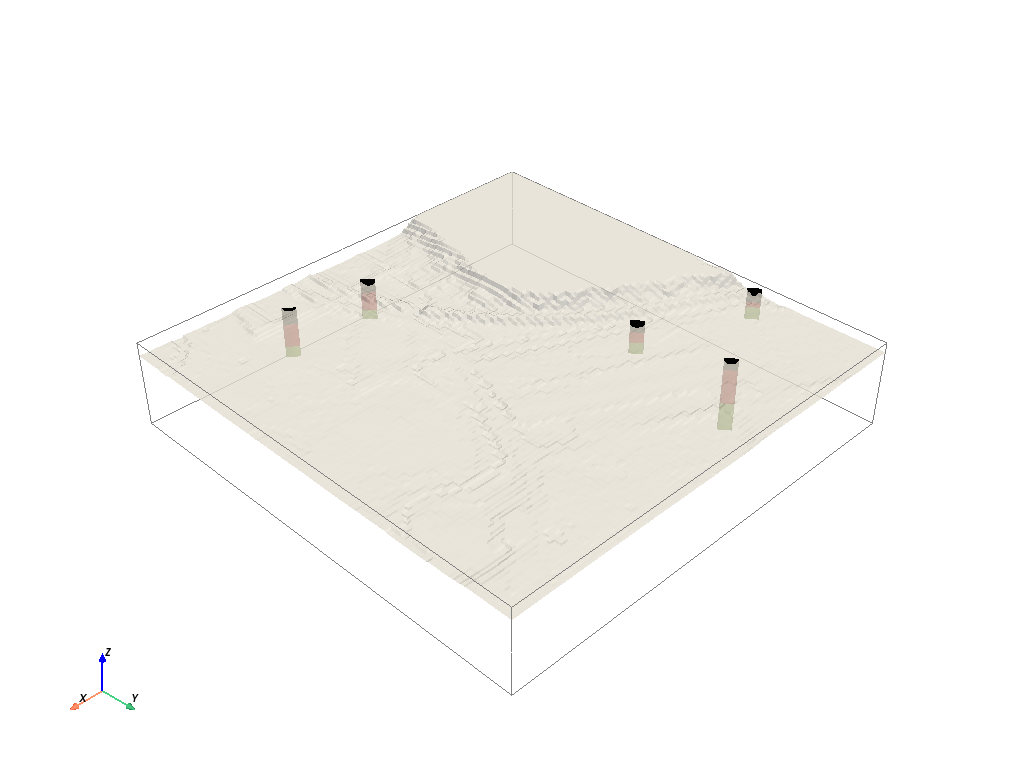

In [28]:
T1.plot_bhs(plot_top=True)

In [29]:
T1.process_bhs()

##### ORDERING UNITS ##### 
Pile Pile_1: ordering units
Stratigraphic units have been sorted according to order
hierarchical relations set

 ## Computing distributions for Normal Score Transform ##

Processing ended successfully


In [30]:
import shutil
import os

#if os.path.exists(folder):
# shutil.rmtree(r"C:\Users\35191\Gempydocs\pile")

In [31]:
T1.ws = "working"

In [32]:
T1.compute_surf(1)

########## PILE Pile_1 ##########
Pile Pile_1: ordering units
Stratigraphic units have been sorted according to order

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.09391427040100098 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.041768550872802734 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.21474242210388184 s
##########################


### 0.4096682071685791: Total time elapsed for computing surfaces ###


In [35]:
T1.compute_distribution()


 ## Computing distributions for Normal Score Transform ##



In [38]:
T1.get_proportions(type="facies")

{'gravel': 0.0958797615962685,
 'clay': 0.42757190982119714,
 'silt': 0.3083700440528635,
 'bedrock': 0.1508162736460223,
 'sand': 0.017362010883648585}

In [11]:
T1.compute_facies(1)

NameError: name 'T1' is not defined

In [12]:
T1.compute_prop(1)

NameError: name 'T1' is not defined

# Retrieve results

In [ ]:
p = pv.Plotter()
v_ex = 1
T1.plot_units(plotter=p, slicex=(0.5), slicey=(0.5),v_ex=v_ex)
p.show()

In [ ]:
p = pv.Plotter()
v_ex = 1

T1.plot_units(0, v_ex=v_ex, plotter=p, slicex=(0.2, 0.5, 0.8), slicey=(0.2, 0.5, 0.8))
T1.plot_bhs(plotter=p, v_ex=v_ex)
p.show()

In [ ]:
#cross section
#first a list of points must be defined
p1 = [5498180, 5664565]
p2 = [5498002.6, 5664473]
p3 = [5498201.7, 5664397.7]
p4 = [5498415.2, 5664001]
p5 = [5498554.6, 5663971.8]
T1.plot_cross_section([p1,p2,p3, p4, p5],typ='units',iu=0,ratio_aspect=2, dist_max=10, width=10)

In [ ]:
T1.plot_units(v_ex=1)

In [ ]:
p = pv.Plotter()
v_ex=v_ex
T1.plot_facies(plotter=p, slicex=(0.5), slicey=(0.5),v_ex=v_ex)
p.show()

In [ ]:
#cross section
#first a list of points must be defined
p1 = [5498180,5664565]
p2 = [5498002.6,5664473]
p3 = [5498201.7,5664397.7]
T1.plot_cross_section([p1,p2,p3],typ='facies',iu=0,ratio_aspect=2, dist_max=100, width=3)

In [ ]:
T1.plot_facies(0,0,inside_units=[C], v_ex=1)

In [ ]:
T1.plot_prop("K mean [log10(m/s)]")

In [ ]:
T1.plot_prop("K mean [log10(m/s)]",0, slicex=0.5,slicey=0.5,slicez=0.5)

In [ ]:
T1.plot_mean_prop("K mean [log10(m/s)]", slicex=(0.2, 0.5, 0.8), slicey=(0.2, 0.5, 0.8), v_ex=v_ex)

In [ ]:
T1.plot_units(slicex=0.5,slicey=0.5,slicez=0.65)

## Uncertainty analysis

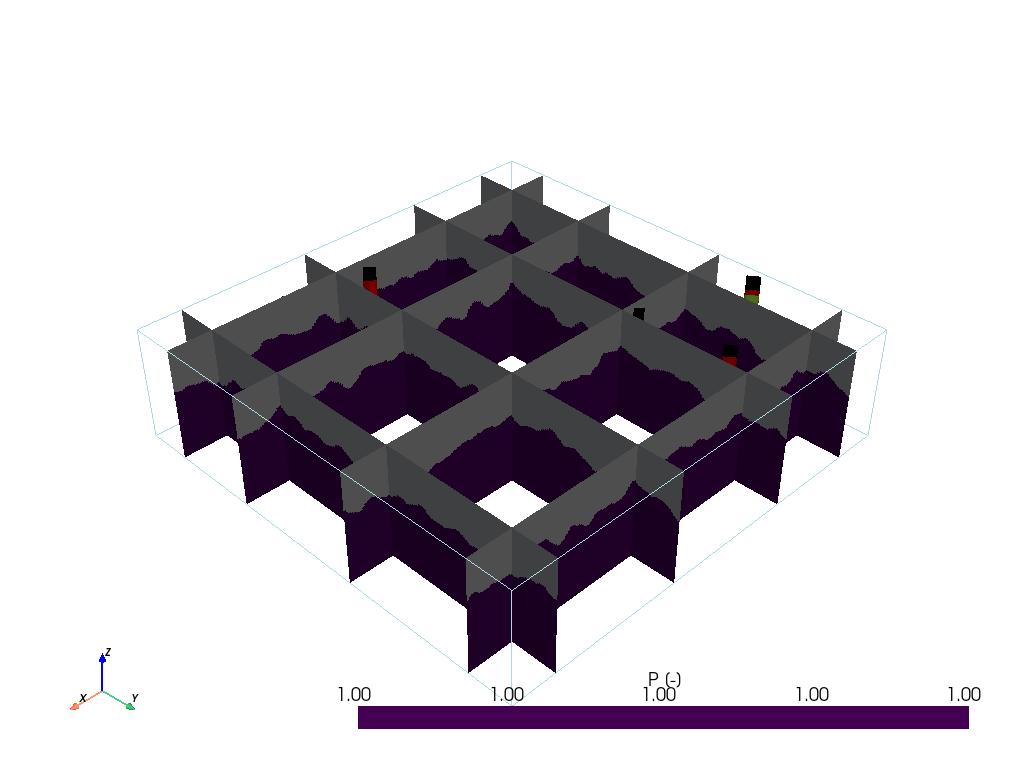

In [44]:
p = pv.Plotter()

#T1.plot_units(2,plotter=p, slicey=(0.1, 0.31, 0.6, 0.9),slicex=(0.1, 0.8, 0.3, 0.6, 0.9))
T1.plot_proba(A, plotter=p, slicey=(0.1, 0.3, 0.6, 0.9),slicex=(0.1, 0.3, 0.6, 0.9))
T1.plot_bhs(plotter=p)
p.show()